<a href="https://colab.research.google.com/github/chanzae/NLP_study/blob/main/bh_patition_BERT_ver01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# 버전 다운
!pip install transformers==2.11.0
!pip install tensorflow==2.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 674 kB 28.0 MB/s 
     |████████████████████████████████| 880 kB 54.4 MB/s 
     |████████████████████████████████| 1.2 MB 48.9 MB/s 
     |████████████████████████████████| 5.6 MB 4.2 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=8015de10bc2da3c0f2a45afe43b7e1ee9df547bf3d3736c3d48991632b73ea01
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 516.2 MB 4.4 kB/s 
     |████████████████████████████████| 3.0 MB 47.0 MB/s 
     |████████████████████████████████| 454 kB 67.4 MB/s 
     |████████████████████████████████| 2.9 MB 57.4 MB/s 
     |████████████████████████████████| 2

# **패키지 설치**

In [7]:
import os
import re
import json
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

from tqdm import tqdm
import tensorflow as tf
from transformers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint 

In [29]:
tf.random.set_seed(777)
np.random.seed(777)

# **데이터 로드**

In [30]:
import pandas as pd

train = pd.read_csv('/content/drive/MyDrive/bh_petition/train.csv')
test = pd.read_csv('/content/drive/MyDrive/bh_petition/test.csv')

In [31]:
train.head()

,index,category,data
0,0,2,신혼부부위한 주택정책 보다 보육시설 늘려주세요.. 국민세금으로 일부를 위한 정책펴지...
1,1,0,학교이름에 '남자'도 붙여주세요. 울산여자중학교에 재학중인 학생입니다 최근 양성평등...
2,2,1,"빙상연맹, 대한축구협회등 각종 체육협회의 비리를 철저하게 밝혀주세요.. 최근 동계올..."
3,3,1,"티비 12세,15세 관람가도 연령확인 의무화 하자.. 제기 에전에 티비를 보다가 잠..."
4,4,1,무더운 여름철엔 남성들도 시원한 자율복장을 해야. 무더운 여름철에는 남성들도 노넥타...


### 결측치 확인

In [55]:
train.isnull().sum()  # data 8건
train_data = train.dropna()

test.isnull().sum()  # 결측치 없음
test_data = test

# BertTokenizer

In [50]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 453 kB 68.1 MB/s 


In [169]:
# 텍스트 전처리 - Okt 함수 생성
import re
import konlpy
from konlpy.tag import Okt

okt = Okt()

def clean_text(texts):
    sent = texts
    # sent_corpus = []
    
    # sent = re.sub(r'\d+','',sent) # 숫자 제거
    sent = re.sub(r'\\n',' ',sent) # 줄바꿈 -> 공백하나
    sent = re.sub(r'[^가-힣ㄱ-하-l ]','',sent) # 한글만
    sent = re.sub(r'^\s+','',sent) # 첫 공백 제거
    sent = re.sub(r'\s+$','',sent) # 끝 공백 제거
    sent = re.sub(r'[.,/?~><\'\";:\[\]\{\}\-\=\+\\!@#$%^&*()|_l]','',sent) #특수문자 제거
    sent = re.sub(r'\s+',' ',sent) # 띄어쓰기 여러개 -> 한개
  
    # stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','을']
    # tokens = okt.morphs(sent) # 어간추출
    # tokens = [word for word in tokens if word not in stopwords if len(word) > 1] # 불용어 제거, 한글자 이상 단어만 추출

    # return tokens
    return sent
    
# 토큰화 함수 생성

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', cache_dir = 'bert_ckpt', do_lower_case = False)
def bert_tokenizer(sentence, MAX_LEN):

  encoded_dict = tokenizer.encode_plus(
      text = sentence,
      add_special_tokens = True,
      max_length = MAX_LEN,
      pad_to_max_length = True,
      return_attention_mask = True
  )

  input_id = encoded_dict['input_ids']
  attention_mask = encoded_dict['attention_mask']
  token_type_id = encoded_dict['token_type_ids']

  return input_id, attention_mask, token_type_id

In [171]:
clean_data = train_data['data'].apply(clean_text)
max_num = 0

for data in tqdm(clean_data):
  splited = data.split(' ')
  len_num = len(splited)
  if len_num >= max_num :
    max_num = len_num

print(f'문장의 최대 단어수는 {max_num}입니다.')

100%|██████████| 39992/39992 [00:00<00:00, 132695.25it/s]

문장의 최대 단어수는 6420입니다.


In [196]:
BATCH_SIZE = 32
NUM_EPOCHS = 3
VALID_SPLIT = 0.3
MAX_LEN = 100

In [197]:
input_ids = []
attention_masks = []
token_type_ids = []
train_data_labels = []

for train_sentence, train_label in tqdm(zip(train_data['data'], train_data['category']), total = len(train_data)):
  try:
    input_id, attention_mask, token_type_id = bert_tokenizer(clean_text(train_sentence), MAX_LEN)

    input_ids.append(input_id)
    attention_masks.append(attention_mask)
    token_type_ids.append(token_type_id)
    train_data_labels.append(train_label)

  except Exception as e:
    print(e)
    pass

train_bh_input_ids = np.array(input_ids, dtype = int)
train_bh_attention_masks = np.array(attention_masks, dtype = int)
train_bh_token_type_ids = np.array(token_type_ids, dtype = int)
train_bh_input = (train_bh_input_ids,train_bh_attention_masks,train_bh_token_type_ids)
train_data_labels = np.array(train_data_labels, dtype = np.int32)

print(f"Sentences : {len(train_bh_input_ids)}\nLabels : {len(train_data_labels)}")

100%|██████████| 39992/39992 [02:11<00:00, 304.17it/s]


Sentences : 39992
Labels : 39992


In [199]:
idx = 0
input_id = train_bh_input_ids[idx]
attention_mask = train_bh_attention_masks[idx]
token_type_id = train_bh_token_type_ids[idx]

print(input_id)
print(attention_mask)
print(token_type_id)
print(tokenizer.decode(input_id))

[   101   9487 119439  14646  14646  19855  11102   9689 119342  16605
 119254 106154   9356  83811  14040  31928   9044  26737  16323  24982
  48549   8909  36553  24982  40032  11467  47807  11513  28195   9670
 119254 119396  12508   9246  14040  11664   9356  50450  17022  25701
  20479  36553  10739   9460 118665  14843   9460  13767   9357  12508
  16605 119254   9923   9689  14040 118666   9318 118853  48345   9663
  12092   9487 119439  14646  14646  44359  19105   9067 119260  24683
   9405  61250   9202 118839  24683  80956  16323 119342  16605 119254
   9321  14423  33188  48345   8909  36553  24982  40032  10622  47807
   9405  61250  61688   9913  16323  12310  21155  10739   9098    102]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0

In [26]:
# 훈련용, 검증용 데이터 분리
# from sklearn.model_selection import train_test_split

# x_tr, y_tr, x_val, y_val = train_test_split(train_bh_input_ids, train_data_labels, test_size = 0.3, stratify = train_data_labels, random_state = 777) 

In [200]:
class TFBertClassifier(tf.keras.Model):
  def __init__(self, model_name, dir_path, num_class):
    super(TFBertClassifier, self).__init__()

    self.bert = TFBertModel.from_pretrained(model_name, cache_dir = dir_path)
    self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
    self.classifier = tf.keras.layers.Dense(num_class,
                                            kernel_initializer = tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range),
                                            name = 'classifier')
    
  def call(self, inputs, attention_mask = None, token_type_ids = None, training = False):
    outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids = token_type_ids)
    pooled_output = outputs[1]
    pooled_output = self.dropout(pooled_output, training = training)
    logits = self.classifier(pooled_output)

    return logits

cls_model = TFBertClassifier(model_name = 'bert-base-multilingual-cased',
                             dir_path = '/content/drive/MyDrive/bert_ckpt',
                             num_class = 3)

# **모델 학습**

In [201]:
optimizer = tf.keras.optimizers.Adam(3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

cls_model.compile(optimizer=optimizer, loss = loss, metrics = [metric])

In [202]:
model_name = 'tf2_bert_bh_patition'

# 얼리스탑 콜백 설정
es_callback = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.0001, patience = 2)

# 체크포인트 경로 생성
checkpoint_path = os.path.join('/content/drive/MyDrive/', model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_path):
  print(f'{checkpoint_dir} Directory already exists\n')
else:
  os.makedirs(checkpoint_dir, exist_ok = True)
  print(f'{checkpoint_dir} Directory create complete\n')

# 체크포인트 설정
cp_callback = ModelCheckpoint(checkpoint_path, monitor = 'val_accuracy',
                              verbose = 1, save_best_only = True, save_weights_only = True)

# 모델 학습
history = cls_model.fit(train_bh_input, train_data_labels,
                        epochs = NUM_EPOCHS, batch_size = BATCH_SIZE, validation_split = VALID_SPLIT,
                        callbacks = [es_callback, cp_callback])

print(history.history)

/content/drive/MyDrive/tf2_bert_bh_patition Directory create complete

Epoch 1/3
875/875 [==============================] - ETA: 0s - loss: 0.4445 - accuracy: 0.8245
Epoch 00001: val_accuracy improved from -inf to 0.83789, saving model to /content/drive/MyDrive/tf2_bert_bh_patition/weights.h5
875/875 [==============================] - 724s 827ms/step - loss: 0.4445 - accuracy: 0.8245 - val_loss: 0.3986 - val_accuracy: 0.8379
Epoch 2/3
875/875 [==============================] - ETA: 0s - loss: 0.3337 - accuracy: 0.8698
Epoch 00002: val_accuracy improved from 0.83789 to 0.86556, saving model to /content/drive/MyDrive/tf2_bert_bh_patition/weights.h5
875/875 [==============================] - 728s 833ms/step - loss: 0.3337 - accuracy: 0.8698 - val_loss: 0.3519 - val_accuracy: 0.8656
Epoch 3/3
875/875 [==============================] - ETA: 0s - loss: 0.2787 - accuracy: 0.8926
Epoch 00003: val_accuracy improved from 0.86556 to 0.86739, saving model to /content/drive/MyDrive/tf2_bert_bh_pati

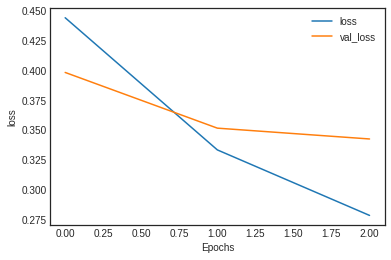

In [203]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'],'')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend(['loss','val_loss'])
plt.show()

# **모델 평가**

In [206]:
# 학습 데이터 평가
cls_model.evaluate(train_bh_input, train_data_labels, batch_size = 1024)   # [loss, accuracy]

40/40 [==============================] - 279s 7s/step - loss: 0.2431 - accuracy: 0.9062


[0.24313871562480927, 0.9062062501907349]

In [ ]:
# 테스트 데이터 
input_ids = []
attention_masks = []
token_type_ids = []
test_data_labels = []

for test_sentence in tqdm(test_data['data']):
  try:
    input_id, attention_mask, token_type_id = bert_tokenizer(test_sentence, MAX_LEN)

    input_ids.append(input_id)
    attention_masks.append(attention_mask)
    token_type_ids.append(token_type_id)

  except Exception as e:
    print(e)
    pass

test_bh_input_ids = np.array(input_ids, dtype = int)
test_bh_attention_masks = np.array(attention_masks, dtype = int)
test_bh_token_type_ids = np.array(token_type_ids, dtype = int)
test_bh_input = (test_bh_input_ids,test_bh_attention_masks,test_bh_token_type_ids)


In [ ]:
pred_result = cls_model.predict(test_bh_input)